In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import init
from tabulate import tabulate
import csv
from focal_Loss import *
from utility import *
from torch.utils.tensorboard import SummaryWriter  


# Read dataset

In [2]:
data_name = "SC1000"
# data_name = "CFL30"

data_path = "DataSet"+data_name+"/"
split = [0.70,0.15,0.15]

dataSet = load_data(data_path)

data_train,data_validation,data_test = torch.utils.data.random_split(dataSet,[int(len(dataSet) * s) for s in split])
# print(dataSet[0]['A'])
# for l in dataSet[0]['A']:
#     for i in l:
#         print(int(i!=0),end = '\t')
#     print()

# data_train_X,data_train_Y,data_validation_X,data_validation_Y,data_test_X,data_test_Y,A = load_data()
# print(data_train_X.shape)
# print(data_train_Y.shape)
# print(A.shape)
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(device)
if device == torch.device("cuda"):
#     torch.cuda.empty_cache()
    data_train_gpu = []
    for i in range(len(data_train)):
        inputs, labels = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_train[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_train_gpu.append([inputs,labels,A])
    data_valide_gpu = []
    for i in range(len(data_validation)):
        inputs, labels = torch.from_numpy(data_validation[i]['X']).float(),torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_validation[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_valide_gpu.append([inputs,labels,A])
        
    data_test_gpu = []
    for i in range(len(data_test)):
        inputs, labels = torch.from_numpy(data_test[i]['X']).float(),torch.from_numpy(data_test[i]['Y']).type(torch.FloatTensor).float()
        A = torch.from_numpy(data_test[i]['A']).float()
        inputs = inputs.to(device)
        labels = labels.to(device)
        A = A.to(device)
        data_test_gpu.append([inputs,labels,A])

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:37<00:00,  3.07it/s]


cuda


In [3]:
def valide(model,criterion,data_validation,proportion = 0.7):
        vloss = []
        accuracy_value = []
        accuracy_instance = []
        
        accuracy_one = []
        accuracy_one_predict = []
        nb_predict_one = []
        nb_one = []
        
        accuracy_zero = []
        accuracy_zero_predict = []
        nb_zero = []
        nb_predict_zero = []
        
        accuracy_fixe_one = []
        accuracy_fixe_zero = []  
        accuracy_fixe = []
        
        data_size = len(data_validation)
        for i in range(data_size):
            if device == torch.device("cuda"):
                inputs, labels = data_validation[i][0],data_validation[i][1]#torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A =data_validation[i][2]# torch.from_numpy(data_train[i]['A']).float()
            else:
                inputs, labels =torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A =torch.from_numpy(data_train[i]['A']).float()
            predictions = model(inputs,A)[:len(labels)].squeeze(dim=-1)
            loss =criterion(predictions,labels)
            A = A.cpu()
            labels = labels.cpu()
            predictions = predictions.cpu()
            
            nb_one_total = torch.sum(torch.where(labels == 1,1,0))
            nb_zero_total = (len(labels) - nb_one_total)
            aux= torch.Tensor([0.5])
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == labels,1,0)
            vloss.append(loss.cpu().detach().numpy())
            accuracy_value.append(is_equal.cpu().sum().detach().numpy()/
                           len(labels))
            accuracy_instance.append(int(accuracy_value[-1]==1))
            #accuracy proportion
            predictions_abs =  np.abs(0.5 - predictions.detach().numpy())
            thresholds = abs(np.sort(-predictions_abs))[int(proportion * len(predictions.cpu().detach().numpy()))- 1]
#             thresholds_low = np.sort(predictions_abs)[int(proportion_low * nb_zero_total]
#             thresholds_up = abs(np.sort(-predictions_abs))[int(proportion_up * nb_one_total)]
            
            #accuracy for differents labels(0 or 1)
            nb_one_fixe = 0
            nb_zero_fixe = 0
            nb_correct_one = 0
            nb_correct_zero = 0
            nb_correct_fixe_one = 0
            nb_correct_fixe_zero = 0
            nb_correct_fixe = 0
            nb_fixe = 0 
            for j,v in enumerate(is_equal):
                if labels[j] == 1:
                    nb_correct_one += v
                else:
                    nb_correct_zero += v

                if predictions_abs[j] >= thresholds:             
                    if labels[j]:
                        nb_correct_fixe_one += v
                    else:
                        nb_correct_fixe_zero += v
                        
                    if y_hat[j]:
                        nb_one_fixe += 1
                    else:
                        nb_zero_fixe += 1

#                 if predictions_abs[j] <= thresholds_low:
#                     if labels[j] == 0:
#                         nb_correct_fixe_zero += v
#                     nb_zero_to_fixe += 1
#                 if predictions_abs[j] >= thresholds_up:
#                     if labels[j] == 1:
#                         nb_correct_fixe_one += v
#                     nb_one_to_fixe += 1
                    
            nb_one_total = torch.sum(torch.where(labels == 1,1,0))
            nb_one_predict = torch.sum(torch.where(y_hat == 1,1,0))
            accuracy_one.append((nb_correct_one/nb_one_total))
            accuracy_one_predict.append((nb_correct_one/nb_one_predict) if nb_one_predict > 0 else 0)
            nb_predict_one.append(nb_one_predict)
            nb_one.append(nb_one_total)
            
            nb_zero_predict = (len(labels) - nb_one_predict)
            accuracy_zero.append((nb_correct_zero/nb_zero_total))
            accuracy_zero_predict.append((nb_correct_zero/nb_zero_predict) if nb_zero_predict > 0 else 0)
            nb_predict_zero.append(nb_zero_predict)
            nb_zero.append(nb_zero_total)
            
            accuracy_fixe.append((nb_correct_fixe_one+nb_correct_fixe_zero)/(nb_one_fixe+nb_zero_fixe))
            accuracy_fixe_one.append(nb_correct_fixe_one/nb_one_fixe if nb_one_fixe>0 else 0)
            accuracy_fixe_zero.append(nb_correct_fixe_zero/nb_zero_fixe if nb_zero_fixe>0 else 0)
            
        #     print(nb_correct_fixe.cpu(),nb_var_fixe)
        #         print(labels,"\n",predictions)
        #         print(labels[0:10],y_hat[0:10])
        msg = ("Loss = %f,Accuracy_value = %f,Accuracy_instance = %f\n"\
              %(np.mean(vloss),np.mean(accuracy_value),np.sum(accuracy_instance)/len(accuracy_instance)))
        msg +=("Label_One_Predict_One = %f,Predict_One_Label_One = %f,Nombre_Predict_One = %f,Nombre_One_Mean = %f\n"\
              %(np.mean(accuracy_one),np.mean(accuracy_one_predict),np.mean(nb_predict_one),np.mean(nb_one)))
        msg +=("Label_Zero_Predict_Zero = %f,Label_Zero_Predict_Zero = %f,Nombre_Predict_Zero = %f,Nombre_Zero_Mean = %f\n"\
              %(np.mean(accuracy_zero),np.mean(accuracy_zero_predict),np.mean(nb_predict_zero),np.mean(nb_zero)))
        msg +=("Accuracy_fixe_mean = %f,Accuracy_fixe_one = %f,Accuracy_fixe_zero = %f\n"\
              %(np.mean(accuracy_fixe),np.mean(accuracy_fixe_one),np.mean(accuracy_fixe_zero)))
        print(msg)
        return msg,np.mean(accuracy_value),np.sum(accuracy_instance)/len(accuracy_instance),np.mean(accuracy_fixe_one),np.mean(accuracy_fixe_zero)

# GCN

In [4]:
class simpleMLP(nn.Module):
    def __init__(self, input_size, out_size,activate = nn.ReLU()):
        super(simpleMLP, self).__init__()
        self.linear = nn.Linear(input_size, out_size)
        self.activate = activate
        
    def forward(self, x):
        x = self.linear(x)
        x = self.activate(x)
        return x
    
class GNN(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP,layerNorm = False):
        super(GNN,self).__init__()
        self.size_mlp = nb_MLP
        self.mlp = nn.ModuleList(
            [simpleMLP(input_size, hidden_size)]+[simpleMLP(hidden_size, hidden_size)]+[simpleMLP(hidden_size*2, hidden_size) for i in range(self.size_mlp - 2)]   
        )
        self.layerNorm = nn.ModuleList(
            [nn.LayerNorm(hidden_size) for i in range(self.size_mlp)]
        )
    
    def forward(self, x, A):
        for i in range(self.size_mlp):
            x = self.mlp[i](x)
            y = A @ x
            y = self.layerNorm[i](y)
            if i != 0:
                x = torch.cat([y,x],1)#sum plutot que con
            else:
                x = y
        return x
    
class VariablePredictor(nn.Module):
    def __init__(self, input_size,hidden_size,nb_MLP):
        super(VariablePredictor,self).__init__()
        self.GNN = GNN(input_size,hidden_size,nb_MLP)
        self.outlayer = simpleMLP(hidden_size*2,1,nn.Sigmoid())    
    
    def forward(self,x,A):
        x = self.GNN(x,A)
        return self.outlayer(x)
     

## Train


In [5]:
def train(net,criterion,optm,data_valide,proportion,writer,batch_size = 1,EPOCHS=500,do_valide = True,do_log = True,epochs_continue = 0):
    aux= torch.Tensor([0.5]).to(device)
    for epoch in tqdm(range(epochs_continue,epochs_continue+EPOCHS)):
        #validation
        if do_valide and epoch % 50 == 0:
            v = valide(net,criterion,data_valide,proportion)
            if do_log:
                writer.add_scalar('Accuracy_fixe_one ', v[3], epoch)
                writer.add_scalar('Accuracy_fixe_zero ', v[4], epoch)
        #train
        data_size = len(data_train)
        log = []
        for i in range(data_size):
            if device == torch.device("cuda"):
                train_inputs, train_labels = data_train_gpu[i][0],data_train_gpu[i][1]#torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A =data_train_gpu[i][2]# torch.from_numpy(data_train[i]['A']).float()
            else:
                train_inputs, train_labels = torch.from_numpy(data_train[i]['X']).float(),torch.from_numpy(data_train[i]['Y']).type(torch.FloatTensor).float()
                A = torch.from_numpy(data_train[i]['A']).float()    

            predictions = net(train_inputs,A)[:len(train_labels)].squeeze(dim=-1)
            loss =criterion(predictions,train_labels)
            loss.backward()
            if epoch % batch_size == 0:
                optm.step()
                optm.zero_grad()
            writer.add_scalar('LearningRate',optm.param_groups[0]['lr'], epoch)
            scheduler.step()
            gradient_norm = 0
            for p in net.parameters():
                param_norm = p.grad.detach().data.norm(2)
                gradient_norm += param_norm.item() ** 2
            gradient_norm = gradient_norm ** 0.5

            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == train_labels,1,0)
            acc = is_equal.cpu().sum().detach().numpy()/len(train_labels)
            log.append([loss.cpu().detach().numpy(),acc,gradient_norm])
        
        log = np.array(log).T
        if do_log:
            writer.add_scalar('Loss', np.mean(log[0]), epoch)
            writer.add_scalar('Accuracy', np.mean(log[1]), epoch)
            writer.add_scalar('Gradient_norm', np.mean(log[2]), epoch)


In [6]:
print(device)


cuda


In [17]:
nb_mlp = 3
proportion = 0.8
feature_size = 24
H = 50
info_valide = []
gamma = 0.5
alpha = 0.25
batch_size = 1
EPOCHS = 1000
learning_rate = 0.001
for nb_mlp in [6]:
    criterion = nn.BCELoss()
#     criterion = FocalLoss(gamma=gamma,alpha = alpha)
    if criterion.__str__()=="BCELoss()":
        train_name = data_name+"_BCE_"+\
            nb_mlp.__str__()+"MLP_"+H.__str__()+"TailleH_"+batch_size.__str__()+"batch_size_scheduler10e-6_"+"layernorm+cat_"
    elif criterion.__str__()=="FocalLoss()":
        train_name = data_name+"_FL_"+gamma.__str__()+"Gamma_"+alpha.__str__()+"Alpha_"+\
            nb_mlp.__str__()+"MLP_"+H.__str__()+"TailleH_"+batch_size.__str__()+"batch_size_scheduler"+"layernorm+cat"

    writer = SummaryWriter('./logs/CFL/'+train_name+"/")
    net = VariablePredictor(feature_size,H,nb_mlp)
    net.to(device)
    optm = Adam(net.parameters(), lr = learning_rate)

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optm, gamma=1-10e-6)
    train(net,criterion,optm,data_valide_gpu,proportion,writer,batch_size = batch_size,EPOCHS=EPOCHS,do_valide = True,do_log = True)
    model_path = "model/"+train_name
    torch.save(net.state_dict(),model_path)
    msg=valide(net,criterion,data_test_gpu,proportion = proportion)
    info_valide.append(msg[1:])
    with open('./logs/'+train_name+"/valide_log.txt", "w") as txtfile:
        print("{}".format(msg), file=txtfile)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Loss = 0.690703,Accuracy_value = 0.346762,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.594002,Predict_One_Label_One = 0.026991,Nombre_Predict_One = 806.366667,Nombre_One_Mean = 35.100000
Label_Zero_Predict_Zero = 0.339031,Label_Zero_Predict_Zero = 0.964751,Nombre_Predict_Zero = 418.133333,Nombre_Zero_Mean = 1189.400000
Accuracy_fixe_mean = 0.400582,Accuracy_fixe_one = 0.025992,Accuracy_fixe_zero = 0.969724



  1%|▋                                                                                | 9/1000 [00:13<25:18,  1.53s/it]


KeyboardInterrupt: 

In [12]:
m=valide(net,nn.BCELoss(),data_test_gpu,proportion = 0.9)

Loss = 0.024658,Accuracy_value = 0.990844,Accuracy_instance = 0.400000
Label_One_Predict_One = 0.863333,Predict_One_Label_One = 0.857629,Nombre_Predict_One = 24.155556,Nombre_One_Mean = 23.955556
Label_Zero_Predict_Zero = 0.995078,Label_Zero_Predict_Zero = 0.995374,Nombre_Predict_Zero = 884.733333,Nombre_Zero_Mean = 884.933333
Accuracy_fixe_mean = 0.999796,Accuracy_fixe_one = 0.395556,Accuracy_fixe_zero = 0.999868



## Test

In [13]:
train_name = "SC1000_BCE_3MLP_50TailleH_1batch_size_layernorm+cat"
model_path = "model/"+train_name
criterion = nn.BCELoss()
model = VariablePredictor(24,50,3).to(device)
model.load_state_dict(torch.load(model_path))
valide(model,criterion,data_test_gpu,proportion = 0.8)

Loss = 0.015471,Accuracy_value = 0.994624,Accuracy_instance = 0.622222
Label_One_Predict_One = 0.910637,Predict_One_Label_One = 0.905976,Nombre_Predict_One = 22.155556,Nombre_One_Mean = 22.000000
Label_Zero_Predict_Zero = 0.997140,Label_Zero_Predict_Zero = 0.997300,Nombre_Predict_Zero = 864.511111,Nombre_Zero_Mean = 864.666667
Accuracy_fixe_mean = 1.000000,Accuracy_fixe_one = 0.022222,Accuracy_fixe_zero = 1.000000



('Loss = 0.015471,Accuracy_value = 0.994624,Accuracy_instance = 0.622222\nLabel_One_Predict_One = 0.910637,Predict_One_Label_One = 0.905976,Nombre_Predict_One = 22.155556,Nombre_One_Mean = 22.000000\nLabel_Zero_Predict_Zero = 0.997140,Label_Zero_Predict_Zero = 0.997300,Nombre_Predict_Zero = 864.511111,Nombre_Zero_Mean = 864.666667\nAccuracy_fixe_mean = 1.000000,Accuracy_fixe_one = 0.022222,Accuracy_fixe_zero = 1.000000\n',
 0.994624074074074,
 0.6222222222222222,
 0.022222222222222223,
 1.0)

# Analyse


In [13]:
def predict(model,data_validation):
        predictions_values = []
        is_predict_correct = []
        data_size = len(data_validation)
        y_hats = []
        labels = []
        for i in range(data_size):
            if data_validation[0][0].device == "cpu":
                inputs, label = torch.from_numpy(data_validation[i]['X']).float(),\
                                torch.from_numpy(data_validation[i]['Y']).type(torch.FloatTensor).float()
                A = torch.from_numpy(data_validation[i]['A']).float()
                inputs = inputs.to(device)
                label = label.to(device)
                A = A.to(device)
            else:
                inputs, label = data_validation[i][0],data_validation[i][1]
                A =data_validation[i][2]
                
            predictions = model(inputs,A)[:len(label)].squeeze(dim=-1)
            label = label.cpu()
            predictions = predictions.cpu()
            predictions_values.append(predictions)

            aux= torch.Tensor([0.5])
            y_hat = (predictions > aux).float() * 1
            is_equal = torch.where(y_hat == label,1,0)
            is_predict_correct.append(is_equal)
            y_hats.append(y_hat)
            labels.append(label)
        return predictions_values,labels,y_hats,is_predict_correct

def fixe_proportionally(predictions_values,labels,y_hat,is_predict_correct,proportion = 0.7): 
        hist_nb_one_fixe = []
        hist_nb_zero_fixe = []
        accuracy_fixe_one = []
        accuracy_fixe_zero = []  
        
        data_size = len(predictions_values)
        for i in range(data_size):
            problem_size = len(y_hat[i])
            nb_one_total = torch.sum(torch.where(labels[i] == 1,1,0))
            nb_zero_total = (problem_size - nb_one_total)
            aux= torch.Tensor([0.5])
            predictions_norm =  np.abs(0.5 - predictions_values[i].detach().numpy())
            thresholds = abs(np.sort(-predictions_norm))[int(proportion * problem_size)- 1]
            nb_one_fixe = 0
            nb_zero_fixe = 0
            nb_correct_fixe_one = 0
            nb_correct_fixe_zero = 0
            nb_correct_fixe = 0
            nb_fixe = 0 
            for j,v in enumerate(is_predict_correct[i]):
                if predictions_norm[j] >= thresholds:             
                    if labels[i][j]:
                        nb_correct_fixe_one += v
                    else:
                        nb_correct_fixe_zero += v
                        
                    if y_hat[i][j]:
                        nb_one_fixe += 1
                    else:
                        nb_zero_fixe += 1
            hist_nb_one_fixe.append(nb_one_fixe)
            hist_nb_zero_fixe.append(nb_zero_fixe)
            accuracy_fixe_one.append(nb_correct_fixe_one/nb_one_fixe if nb_one_fixe>0 else 0)
            accuracy_fixe_zero.append(nb_correct_fixe_zero/nb_zero_fixe if nb_zero_fixe>0 else 0)
        return np.mean(accuracy_fixe_one),np.mean(hist_nb_one_fixe),np.mean(accuracy_fixe_zero),np.mean(hist_nb_zero_fixe)
    
def fixe_one_epsilon(predictions_values,y_hats,labels,e = 0.01):
    nbs_fixe = []
    accs_fixe = []
    props = []
    data_size = len(data_validation)
    thresholds = 1 - e
    for i in range(data_size):
        problem_size = len(labels[i])
        nb_fixe = 0
        nb_correct_fixe = 0
        nb_one_total = torch.sum(torch.where(labels[i] == 1,1,0))
        for j in range(problem_size):
            if predictions[i][j] >= thresholds:  
                nb_fixe += 1
                if y_hats[i][j] and labels[i][j]:
                    nb_correct_fixe += 1
        nbs_fixe.append(nb_fixe)
        accs_fixe.append(nb_correct_fixe/nb_fixe if nb_fixe > 0 else 0)        
        props.append(nb_correct_fixe/nb_one_total)
    return np.mean(accs_fixe),np.mean(nbs_fixe),np.mean(props)

def get_cost_effective(data_instance):
    features = data_instance[0]
    labels = data_instance[1]
    size = len(labels)
    A=data_instance[2] 
    return [float(features[i][0]/sum(torch.where(A[i]==0,0,1))) for i in range(size)]



    

In [218]:
_ = valide(net,criterion,[data_test_gpu[0]],proportion = 1)

Loss = 0.033526,Accuracy_value = 0.985000,Accuracy_instance = 0.000000
Label_One_Predict_One = 0.800000,Predict_One_Label_One = 0.848485,Nombre_Predict_One = 33.000000,Nombre_One_Mean = 35.000000
Label_Zero_Predict_Zero = 0.993464,Label_Zero_Predict_Zero = 0.990874,Nombre_Predict_Zero = 767.000000,Nombre_Zero_Mean = 765.000000
Accuracy_fixe_mean = 0.985000,Accuracy_fixe_one = 0.848485,Accuracy_fixe_zero = 0.990874



In [15]:
prediction_mean = np.zeros((500))
data_size = len(data_test_gpu)
for i in tqdm(range(data_size)):
    cost_effective = get_cost_effective(data_test_gpu[i])
    aux_dict = {}
    for j,v in enumerate(cost_effective):
        aux_dict[j] = v
    aux_dict = sorted(aux_dict.items(), key = lambda kv:(kv[1], kv[0]))
    inputs, label = data_test_gpu[i][0],data_test_gpu[i][1]
    A =data_test_gpu[i][2]

    predictions = net(inputs,A)[:len(label)].squeeze(dim=-1)
    label = label.cpu()
    predictions = predictions.cpu()

    cost_effective_reorder = []
    predictions_reorder=[]
    for idx in range(len(prediction_mean)):
        prediction_mean[idx]+=float(predictions[aux_dict[idx][0]])


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [13:58<00:00, 18.63s/it]


In [21]:
A = A.cpu().numpy()

In [63]:
size = int(A.shape[0]/2)
print(A[:size,size:])

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  -0.04981355]
 [ 0.          0.          0.         ... -0.05234239  0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [164]:
score = get_cost_effective(data_test_gpu[0])

In [16]:
def heuristique(score,A):
    size = len(score)
    size_cons = A.shape[0] - size
    A = A.cpu().numpy()[:size,size_cons:]
    solution = np.zeros((size))
    nb_cover_original = [len(np.where(A[i]==0)[0])for i in range(size)]
    while len(A[0]) > 0:
        nb_cover = [len(np.where(A[i]!=0)[0]) for i in range(size)]
        i_max = 0
        v_max = 0
        for i,v in enumerate(score):
            aux = v * nb_cover[i] / nb_cover_original[i]
            if aux > v_max :
                i_max = i
                v_max = aux
        solution[i_max] = 1
        for i_cons in np.where(A[i_max]!=0)[0][::-1]:
            A = np.delete(A, i_cons, axis=1)
    return solution

In [14]:
train_name = "SC1000_BCE_3MLP_50TailleH_1batch_size_layernorm+cat"
model_path = "model/"+train_name
criterion = nn.BCELoss()
net = VariablePredictor(24,50,3).to(device)
net.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [ ]:
valide(net,criterion,data_test_gpu,proportion = 0.8)

In [18]:
data_size = len(data_test_gpu)
# nb_corrects = [[],[],[]]
nb_corrects = [[],[]]
accs = [[],[],[]]
for i in tqdm(range(data_size)):
    predictions = net(data_test_gpu[i][0],data_test_gpu[i][2]).squeeze(dim=-1)[:len(data_test_gpu[i][1])]
    aux= torch.Tensor([0.5]).to(device)
    y_hat = (predictions > aux).float() * 1
    res_gcn = y_hat.cpu().numpy()

#     score = get_cost_effective(data_test_gpu[i])
#     res_coute = heuristique(score,data_test_gpu[i][2])

    res_prect = heuristique(predictions,data_test_gpu[i][2])

    labels = data_test_gpu[i][1].cpu().numpy()
    # print(np.where(res_coute==1),np.where(res_gcn==1),np.where(labels==1),np.where(res_prect==1))
    for k,res in enumerate([res_gcn,res_prect]):##,res_coute]):
        print(len(res_gcn),len(res_prect))#,len(res_coute))
        nb_corret = 0
        for j,v in enumerate(res):
            nb_corret += int(v == labels[j] and v == 1)
        nb_corrects[k].append(nb_corret)
        accs[k].append(nb_corret/len(np.where(res==1)[0]))
for i in accs:
    print(np.mean(i))

  0%|                                                                                           | 0/45 [00:00<?, ?it/s]

1000
1000


  2%|█▊                                                                                 | 1/45 [00:03<02:55,  3.99s/it]

1000 1000
1000 1000
1000
800


  4%|███▋                                                                               | 2/45 [00:08<03:15,  4.54s/it]

800 800
800 800
800
1000


  7%|█████▌                                                                             | 3/45 [00:12<02:50,  4.05s/it]

1000 1000
1000 1000
1000
500


  9%|███████▍                                                                           | 4/45 [00:14<02:15,  3.31s/it]

500 500
500 500
500
1200


 11%|█████████▏                                                                         | 5/45 [00:48<09:38, 14.46s/it]

1200 1200
1200 1200
1200
800


 13%|███████████                                                                        | 6/45 [00:53<07:08, 10.99s/it]

800 800
800 800
800
1200


 16%|████████████▉                                                                      | 7/45 [01:25<11:29, 18.13s/it]

1200 1200
1200 1200
1200
1000


 18%|██████████████▊                                                                    | 8/45 [01:28<08:11, 13.28s/it]

1000 1000
1000 1000
1000
1000


 20%|████████████████▌                                                                  | 9/45 [01:31<05:58,  9.97s/it]

1000 1000
1000 1000
1000
1000


 22%|██████████████████▏                                                               | 10/45 [01:35<04:41,  8.05s/it]

1000 1000
1000 1000
1000
800


 24%|████████████████████                                                              | 11/45 [01:37<03:37,  6.39s/it]

800 800
800 800
800
500


 27%|█████████████████████▊                                                            | 12/45 [01:39<02:40,  4.87s/it]

500 500
500 500
500
1000


 29%|███████████████████████▋                                                          | 13/45 [01:42<02:17,  4.29s/it]

1000 1000
1000 1000
1000
800


 31%|█████████████████████████▌                                                        | 14/45 [01:46<02:17,  4.42s/it]

800 800
800 800
800
800


 33%|███████████████████████████▎                                                      | 15/45 [01:49<01:56,  3.88s/it]

800 800
800 800
800
1000


 36%|█████████████████████████████▏                                                    | 16/45 [01:55<02:12,  4.56s/it]

1000 1000
1000 1000
1000
1200


 38%|██████████████████████████████▉                                                   | 17/45 [02:32<06:42, 14.38s/it]

1200 1200
1200 1200
1200
1200


 40%|████████████████████████████████▊                                                 | 18/45 [03:08<09:16, 20.62s/it]

1200 1200
1200 1200
1200
800


 42%|██████████████████████████████████▌                                               | 19/45 [03:10<06:34, 15.18s/it]

800 800
800 800
800
1000


 44%|████████████████████████████████████▍                                             | 20/45 [03:14<04:55, 11.80s/it]

1000 1000
1000 1000
1000
1000


 47%|██████████████████████████████████████▎                                           | 21/45 [03:20<04:00, 10.00s/it]

1000 1000
1000 1000
1000
500


 49%|████████████████████████████████████████                                          | 22/45 [03:21<02:52,  7.51s/it]

500 500
500 500
500
800


 51%|█████████████████████████████████████████▉                                        | 23/45 [03:24<02:14,  6.10s/it]

800 800
800 800
800
800


 53%|███████████████████████████████████████████▋                                      | 24/45 [03:27<01:46,  5.06s/it]

800 800
800 800
800
1000


 56%|█████████████████████████████████████████████▌                                    | 25/45 [03:33<01:49,  5.46s/it]

1000 1000
1000 1000
1000
1000


 58%|███████████████████████████████████████████████▍                                  | 26/45 [03:39<01:47,  5.67s/it]

1000 1000
1000 1000
1000
1200


 60%|█████████████████████████████████████████████████▏                                | 27/45 [04:14<04:16, 14.23s/it]

1200 1200
1200 1200
1200
1200


 62%|███████████████████████████████████████████████████                               | 28/45 [04:49<05:47, 20.45s/it]

1200 1200
1200 1200
1200
1000


 64%|████████████████████████████████████████████████████▊                             | 29/45 [04:52<04:07, 15.47s/it]

1000 1000
1000 1000
1000
500


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [04:54<02:49, 11.30s/it]

500 500
500 500
500
1000


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [04:57<02:04,  8.87s/it]

1000 1000
1000 1000
1000
500


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [04:59<01:26,  6.67s/it]

500 500
500 500
500
1000


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [05:02<01:07,  5.61s/it]

1000 1000
1000 1000
1000
1000


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [05:06<00:56,  5.14s/it]

1000 1000
1000 1000
1000
500


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [05:07<00:40,  4.05s/it]

500 500
500 500
500
500


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [05:10<00:32,  3.61s/it]

500 500
500 500
500
1200


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [05:47<01:49, 13.67s/it]

1200 1200
1200 1200
1200
1000


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [05:51<01:13, 10.56s/it]

1000 1000
1000 1000
1000
1000


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [05:54<00:49,  8.30s/it]

1000 1000
1000 1000
1000
800


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [05:56<00:33,  6.62s/it]

800 800
800 800
800
800


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [05:59<00:22,  5.55s/it]

800 800
800 800
800
800


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [06:03<00:15,  5.11s/it]

800 800
800 800
800
500


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [06:06<00:08,  4.48s/it]

500 500
500 500
500
1200


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [06:44<00:14, 14.35s/it]

1200 1200
1200 1200
1200
500


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [06:45<00:00,  9.01s/it]

500 500
500 500


0.9059759455721788
0.6178941455705121
nan


C:\Users\Leonaire\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Leonaire\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
predictions = net(data_test_gpu[0][0],data_test_gpu[0][2]).squeeze(dim=-1)[:len(data_test_gpu[0][1])]
aux= torch.Tensor([0.5]).to(device)
y_hat = (predictions > aux).float() * 1
solu0 = y_hat.cpu().numpy()
A0 = data_test_gpu[0][2]

In [36]:
def is_realisable(solu,A):
    size_var = len(solu)
    size_cons = A.shape[0] - size_var
    A = A.cpu().numpy()[:size_var,size_cons:]
#     print(solu,A)
    for i,v in enumerate(solu):
        if v:
#             print(len(np.where(A[i]!=0)[0]))
            for i_cons in np.where(A[i]!=0)[0][::-1]:
                A = np.delete(A, i_cons, axis=1)
    return A.shape[1]

In [37]:
nb_cons_reste = []
for i in tqdm(range(data_size)):
    predictions = net(data_test_gpu[i][0],data_test_gpu[i][2]).squeeze(dim=-1)[:len(data_test_gpu[i][1])]
    aux= torch.Tensor([0.5]).to(device)
    y_hat = (predictions > aux).float() * 1
    solu = y_hat.cpu().numpy()
    A = data_test_gpu[i][2]
    nb_cons_reste.append(is_realisable(solu,A))
print(nb_cons_reste)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:26<00:00,  1.69it/s]

[9, 24, 11, 9, 213, 20, 212, 14, 6, 18, 7, 6, 10, 26, 10, 22, 232, 227, 8, 22, 19, 10, 13, 10, 27, 26, 202, 207, 9, 9, 19, 7, 13, 23, 10, 14, 213, 10, 9, 13, 13, 19, 13, 213, 5]


In [68]:
aux=np.array([[1,0,5,6],[0,1,8,4],[6,3,1,0],[7,3,0,1]])
print(np.where(aux[0]!=0))

(array([0, 2, 3], dtype=int64),)


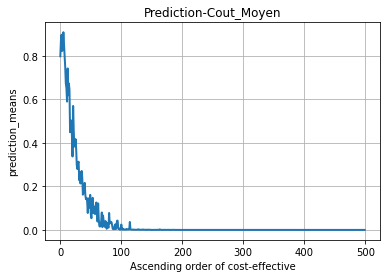

In [16]:
prediction_means = prediction_mean/data_size
fig, ax = plt.subplots()
# acc_one,= ax.plot(range(len(cost_effective_reorder)),cost_effective_reorder, linewidth=2.0,label=r'')
nb_one,= ax.plot(range(len(prediction_means)),prediction_means , linewidth=2.0)
plt.title("Prediction-Cout_Moyen")
plt.xlabel('Ascending order of cost-effective')
plt.ylabel('prediction_means')
plt.savefig("image/Prediction_Cout_Moyen")
plt.grid()
plt.show()

In [100]:
# model_name = data_name+"_MLP"+nb_mlp.__str__()+"Gamma0.5"
nb_mlp = 1
# data_name = "SC1000"

# model_name = data_name+"_MLP"+nb_mlp.__str__()
# model_name = data_name+"_MLP"+nb_mlp.__str__()+"Gamma0.5"
# model_name = "CFL30_NoCov_OnlyOutLayer"
# model_name = "CFL30_BCE_3MLP"
# model_name = "SC1000_NoCov_OnlyOutLayer"
model_name = "SC1000_FL_0.5Gamma_0.25Alpha_1MLP50TailleH"


model_path = "model/"+model_name

model = VariablePredictor(24,50,nb_mlp).to(device)
# model = VariablePredictor_OnlyOutLayer(24,24,nb_mlp).to(device)

model.load_state_dict(torch.load(model_path))
predictions,labels,y_hats,is_corrects = predict(model,data_test_gpu)
# _=valide(model,criterion,data_test_gpu,proportion = 0.9)

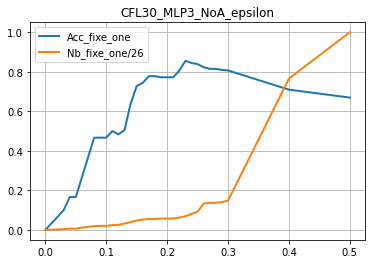

In [139]:
test_epsilon = []
epsilons = [0.01 * i for i in range(0,30,1)]+[0.01 * i for i in range(30,51,10)]
for e in epsilons:
    test_epsilon.append([e]+list(fixe_one_epsilon(predictions,y_hats,labels,e)))
header=["Epsilon", "Accuracy_fixe_one", "Number_fixe_one","Correct_One/Total_One"]
# print(tabulate(test_epsilon, headers=header))

with open("CSV/"+model_name+"_epsilon.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(header)
    writer.writerows(test_epsilon)

fig, ax = plt.subplots()
values = np.array(test_epsilon).T
acc_one,= ax.plot(values[0], values[1], linewidth=2.0,label=r'Acc_fixe_one')
maxv = int(max(values[2]))
nb_one,= ax.plot(values[0], values[2]/maxv, linewidth=2.0,label=r'Nb_fixe_one/'+maxv.__str__())
plt.legend(handles=[acc_one,nb_one],loc="best",)
plt.title(model_name+"_epsilon")
plt.savefig("image/"+model_name+"_epsilon.png")
plt.grid()
plt.show()


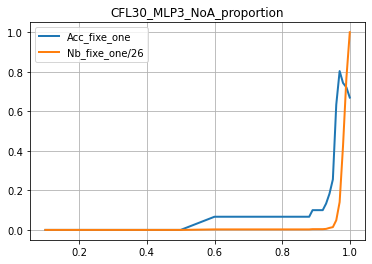

In [140]:
test_values = []
proportions = [0.1 * i for i in range(1,8)]+[0.01 * i for i in range(80,101)]
for p in proportions:
    test_values.append([p]+list(fixe_proportionally(predictions,labels,y_hats,is_corrects,proportion = p)))
header=["Proportion", "Accuracy_fixe_one", "Number_fixe_one","Accuracy_fixe_zero", "Number_fixe_zero"] 
# print(tabulate(test_values, headers=header))

with open("CSV/"+model_name+"_proportion.csv","w") as csvfile: 
    writer = csv.writer(csvfile)
    writer.writerow(header)
    writer.writerows(test_values)

fig, ax = plt.subplots()
values = np.array(test_values).T
acc_one,= ax.plot(values[0], values[1], linewidth=2.0,label=r'Acc_fixe_one')
maxv = int(max(values[2]))
nb_one,= ax.plot(values[0], values[2]/maxv, linewidth=2.0,label=r'Nb_fixe_one/'+maxv.__str__())
plt.legend(handles=[acc_one,nb_one],loc="best",)
plt.title(model_name+"_proportion")
plt.savefig("image/"+model_name+"_prop.png")
plt.grid()
plt.show()